## Notebook to plot ACC Seizure Detection Plots

This notebook is focused solely on FBTC seizures.

First, a patient-independent approach will be tested

SET 1
- Training: BLIW_1, YIVL_0, AGGA_0, AGGA_1, YWJN_5
- Testing: VNVW_1, WOSQ_2, AGGA_2, AGGA_3, YIVL_1, YIVL_2, BLIW_2, BLIW_3, YWJN_6, YWJN_7

Second, a patient-dependent approach will be tested

SET 2
- Training: BLIW_1, BLIW_2, YIVL_0, YIVL_1, AGGA_0, AGGA_1, AGGA_2, YWJN_5, YWJN_6 
- Testing: VNVW_1, WOSQ_2, AGGA_3, YIVL_2,  BLIW_3, YWJN_7

In [2]:
# import os

# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import tsfel


## 1. Open data

In [3]:
data = pd.read_parquet('./data/features/all_patients_acc_features.parquet')

print(data.shape)

# remove columns with nans
data = data.dropna(axis=1)
print(data.shape)
data['patient'] = data['patient_seizure'].apply(lambda x: x.split('_')[0])


(87810, 1559)
(87810, 1557)


## 2. Train test split

In [4]:
training_set_keys = ['BLIW_0', 'BLIW_1', 'BLIW_2', 'YIVL_0', 'YIVL_1', 'AGGA_0', 'AGGA_1', 'AGGA_2', 'YWJN_4', 'YWJN_5', 'YWJN_6'] 
testing_set_keys = ['VNVW_0', 'VNVW_1', 'WOSQ_2', 'AGGA_3', 'YIVL_2',  'BLIW_3', 'YWJN_7']
training_set = data[data['patient_seizure'].isin(training_set_keys)].copy()
testing_set = data[data['patient_seizure'].isin(testing_set_keys)].copy()


In [5]:
features_cols = training_set.drop(columns=['patient_seizure', 'patient', 'timestamp', 'y']).columns

## 3. Features processing

### 3.1 Remove low variance (std lower than 0.005)

In [6]:
training_set.groupby(by='patient')[features_cols].std().min()

ACCM_Absolute energy         126664.949446
ACCM_Area under the curve         3.853724
ACCM_Autocorrelation         126664.949446
ACCM_Average power            12666.494945
ACCM_Centroid                     0.872630
                                 ...      
ACCZ_Wavelet variance_5           0.010167
ACCZ_Wavelet variance_6           0.017861
ACCZ_Wavelet variance_7           0.027729
ACCZ_Wavelet variance_8           0.039134
ACCZ_Zero crossing rate          56.766647
Length: 1554, dtype: float64

In [7]:
# remove features with low standard deviation in training set by patient - if for any patient the feature has low variance it is excluded
new_feature_cols = training_set[features_cols].columns[(training_set.groupby(by='patient')[features_cols].std().min() > 0.005)]
exclude_cols = set(features_cols) - set(new_feature_cols)
print('removed features: ', exclude_cols)
training_set.drop(columns= exclude_cols, inplace=True)
testing_set.drop(columns= exclude_cols, inplace=True)


removed features:  {'ACCM_FFT mean coefficient_84', 'ACCX_FFT mean coefficient_221', 'ACCX_FFT mean coefficient_14', 'ACCZ_Wavelet variance_2', 'ACCX_FFT mean coefficient_224', 'ACCM_FFT mean coefficient_255', 'ACCM_FFT mean coefficient_231', 'ACCM_FFT mean coefficient_208', 'ACCZ_FFT mean coefficient_7', 'ACCX_FFT mean coefficient_128', 'ACCZ_FFT mean coefficient_250', 'ACCY_FFT mean coefficient_34', 'ACCZ_FFT mean coefficient_104', 'ACCM_FFT mean coefficient_160', 'ACCM_FFT mean coefficient_181', 'ACCZ_FFT mean coefficient_99', 'ACCZ_FFT mean coefficient_220', 'ACCM_ECDF Percentile Count_0', 'ACCY_Mean diff', 'ACCX_FFT mean coefficient_145', 'ACCX_FFT mean coefficient_127', 'ACCZ_FFT mean coefficient_123', 'ACCZ_FFT mean coefficient_86', 'ACCY_FFT mean coefficient_253', 'ACCM_FFT mean coefficient_34', 'ACCY_FFT mean coefficient_230', 'ACCZ_FFT mean coefficient_2', 'ACCX_FFT mean coefficient_81', 'ACCZ_FFT mean coefficient_183', 'ACCM_FFT mean coefficient_71', 'ACCY_FFT mean coefficie

In [8]:
features_cols = training_set.drop(columns=['patient_seizure', 'patient', 'y', 'timestamp']).columns

### 3.2. Remove highly correlated features

In [9]:
corr_matrix = training_set[features_cols].corr().abs()

In [9]:
corr_matrix.style.background_gradient(cmap='coolwarm')


In [10]:

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f'Dropping {len(to_drop)} features from {corr_matrix.shape[1]}.')

# Drop features 
#if to_drop[0] in training_set.columns:
#    training_set.drop(to_drop, axis=1, inplace=True)
new_training_set = training_set.drop(columns=to_drop)
new_testing_set = testing_set.drop(columns=to_drop)
features_cols = new_training_set.drop(columns=['patient_seizure', 'timestamp', 'y', 'patient']).columns

print('New shape: ', new_training_set.shape)
print(len(features_cols))

Dropping 42 features from 104.
New shape:  (60720, 66)
62


### 3.3 Robust Standarization

In [11]:
# scaling data - robust standarization
# use the percentiles of the training set to scale the training and the testing sets
## general scaling for all patients
scaled_testing_set = new_testing_set.copy()
scaled_training_set = new_training_set.copy()
perc_50 = new_training_set[features_cols].median(axis=0)
perc_25 = new_training_set[features_cols].quantile(0.25)
perc_75 = new_training_set[features_cols].quantile(0.75)
scaled_training_set[features_cols] = (new_training_set[features_cols] - perc_50) / (perc_75 - perc_25)
scaled_testing_set[features_cols] = (new_testing_set[features_cols] - perc_50) / (perc_75 - perc_25)
print(len(scaled_training_set.isna().columns))
scaled_training_set.dropna(axis=1, inplace=True)
print(scaled_training_set.shape)
new_feature_cols = scaled_training_set.drop(columns=['patient', 'patient_seizure', 'y', 'timestamp']).columns

66
(60720, 65)


In [243]:
# # scaling data - robust standarization
# # use the percentiles of the training set to scale the training and the testing sets
# ## single patient scaling
# scaled_testing_set = new_testing_set.copy()
# scaled_training_set = new_training_set.copy()

# for patient in training_set['patient'].unique():
#     patient_train_set = new_training_set.loc[new_training_set['patient'] == patient]
#     patient_test_set = new_testing_set.loc[new_testing_set['patient'] == patient]
    
#     #a = perc_50 = patient_train_set[features_cols].median(axis=0)
#     #b = perc_25 = patient_train_set[features_cols].quantile(0.25)
#     #c = perc_75 = patient_train_set[features_cols].quantile(0.75)
#     a = patient_train_set[features_cols].mean(axis=0)
#     b = patient_train_set[features_cols].max(axis=0)
#     c = patient_train_set[features_cols].min(axis=0)
#     scaled_training_set.loc[patient_train_set.index, features_cols] = (patient_train_set[features_cols] - c) / (b - c) # minmax
#     scaled_testing_set.loc[patient_test_set.index, features_cols] = (patient_test_set[features_cols] - c) / (b - c) # minmax
# print(len(scaled_training_set.isna().columns))
# new_features_cols = scaled_training_set.drop(columns=['patient_seizure', 'timestamp', 'y', 'patient']).columns
# print(scaled_training_set.shape)


66
(60720, 66)


In [12]:
fig = px.scatter(scaled_training_set, x='ACCM_Absolute energy', y=['ACCM_Human range energy'], color='patient')

fig.show()

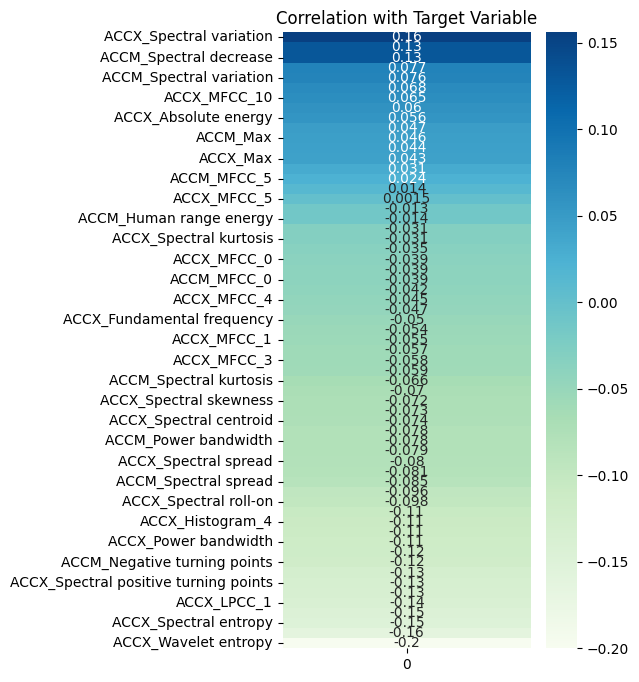

In [13]:
# Create a correlation matrix with target variable
target = new_training_set['y']
corr_with_target = scaled_training_set[new_feature_cols].corrwith(target)

# Sort features by correlation with target variable
corr_with_target = corr_with_target.sort_values(ascending=False)

# Plot the heatmap
plt.figure(figsize=(4, 8))
sns.heatmap(corr_with_target.to_frame(), cmap='GnBu', annot=True)
plt.title('Correlation with Target Variable')
plt.show()

In [14]:
fig = px.scatter(scaled_training_set, y='ACCM_Max', color=target)
fig.show()

In [15]:
X_train = scaled_training_set[new_feature_cols].copy()
y_train = scaled_training_set['y'].copy()
X_test = scaled_testing_set[new_feature_cols].copy()

In [16]:

from sklearn.feature_selection import SelectPercentile, f_classif


percentile = 10
selector_anova = SelectPercentile(score_func=f_classif, percentile=percentile)
X_train_ANOVA = selector_anova.fit_transform(X_train, y_train)
X_test_ANOVA = selector_anova.transform(X_test)


feature_index = selector_anova.get_support(indices=True)
feature_names = X_train.columns[feature_index]

# Convert selected features to DataFrame
features_anova_train1 = pd.DataFrame(X_train_ANOVA, columns=feature_names, index=X_train.index)
features_anova_test1 = pd.DataFrame(X_test_ANOVA, columns=feature_names, index=X_test.index)


In [17]:
feature_names

Index(['ACCM_Spectral positive turning points', 'ACCM_Wavelet entropy',
       'ACCX_LPCC_1', 'ACCX_Spectral entropy', 'ACCX_Spectral variation',
       'ACCX_Wavelet entropy'],
      dtype='object')

In [18]:
#Select the best parameters for SVM - using the Grid Search - cross validation with 5 folds

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#possible parameters of SVC
parameters = {
    'C': [0.1, 1, 10,100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}


SVM = SVC(random_state=42)


grid = GridSearchCV(SVM, parameters, cv=3, scoring='recall')
grid.fit(X_train, y_train)  


print("Best Parameters: ", grid.best_params_)